In [1]:
# Start current environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating environment at `c:\Users\Ub\Documents\Code\BayesianMethodsForHackers\BayesianMethodsGen\Project.toml`
   Installed FunctionalCollections ─ v0.5.0
   Installed FunctionWrappers ────── v1.1.2
   Installed ReverseDiff ─────────── v1.9.0
   Installed Gen ─────────────────── v0.4.4
Precompiling project...
  ✓ FunctionWrappers
  ✓ FunctionalCollections
  ✓ PooledArrays
  ✓ TranscodingStreams
  ✓ WeakRefStrings
  ✓ CodecZlib
  ✓ CSV
  ✓ ReverseDiff
  ✓ DataFrames
  ✓ BayesianMethodsGen
  10 dependencies successfully precompiled in 50 seconds (165 already precompiled)


# Load and visualize the data
CSV supports Tables.jl and can be loaded into a `DataFrame`

`DataFrame` can be converted to another data structure

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1342


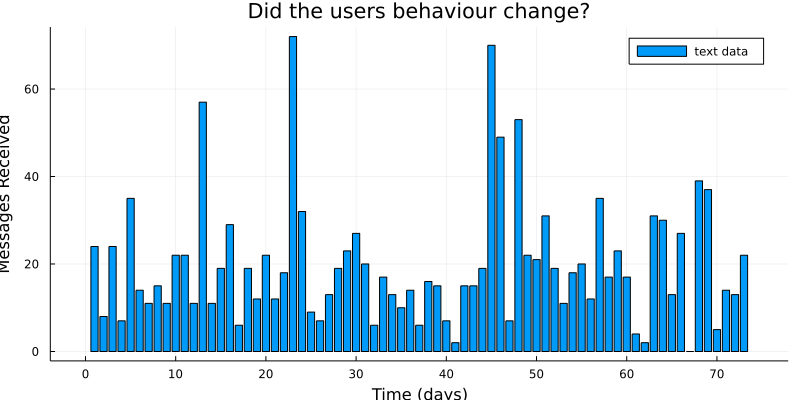

In [2]:
using CSV, DataFrames, StatsPlots
gr(size=(800,400))
txt_df = CSV.File("../data/chapter1/txtdata.csv") |> DataFrame
txt_data = Matrix(txt_df)
bar(txt_data, title="Did the users behaviour change?", xlabel="Time (days)", xticks=0:10:80, ylabel="Messages Received", label="text data")

# Model
- The number of text messages per day is discrete and thus assumed to be Poisson distributed
- It is assumed that the number of received text messages changes once at day $\tau$
- Thus, two different parameters $\lambda_i$ are required for two differen Poisson distributions
- Exponential distribution has expected value as parameter $e^{\theta}$
- Gen's built-in modelling language has two syntaxes for tracing choices:
    - `@trace(<distribution>(<args>), <addr>)`, specify an address of the choice
    - `~` Tilde can automatically infer a name from the variable it is assigned to, alternatively assign an address using `value = {addr} ~ distr(args)`

In [3]:
using Gen
@gen function λ_model(θ::Float64)
  # assignment not required, only returning the correct value for λ is required
  λ = @trace(exponential(θ), :λ)
end;

┌ Info: Precompiling Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1342


In [4]:
@gen function model(data_length::Integer, data_mean::Float64)
  # assumptions
  θ = 1/data_mean
  λ_1 ~ λ_model(θ)
  λ_2 ~ λ_model(θ)
  τ ~ uniform_discrete(1, data_length)
  # observation
  for day in 1:data_length
    if day < τ
      my_var = {:y => day} ~ poisson(λ_1)
    else
      my_var = {:y => day} ~ poisson(λ_2)
    end
  end
end;
# Test the model
trace = simulate(model, (3, 1.0))
get_choices(trace)

│
├── :τ : 1
│
├── :λ_1
│   │
│   └── :λ : 0.38851706544756537
│
├── :λ_2
│   │
│   └── :λ : 0.39919157465554045
│
└── :y
    │
    ├── 2 : 0
    │
    ├── 3 : 0
    │
    └── 1 : 0


# Inference Algorithm
- Gen conditions on variables for which choices have been set in from of a `ChoicemMap`
- Only the choices for the last trace are returned so the values of the chain have to be stored manually
- MCMC is implemented by iteratively applying a kernel to the trace, in this case Metropolis Hastings

In [5]:
using Statistics
function do_inference(data, n_iterations::Integer)
  # wrap the data in choicemap obsevations
  observations = choicemap()
  for (i, value) in enumerate(data)
      observations[:y => i] = value
  end
  # store chain values
  λ_1_chain, λ_2_chain, τ_chain = [],[],[]
  # iteratively apply MH kernel
  trace, = generate(model, (length(data), mean(data)), observations)
  for i=1:n_iterations
    trace, = metropolis_hastings(trace, Gen.select(:λ_1, :λ_2, :τ))
    push!(λ_1_chain, trace[:λ_1])
    push!(λ_2_chain, trace[:λ_2])
    push!(τ_chain, trace[:τ])
  end
  λ_1_chain, λ_2_chain, τ_chain
end
λ_1_chain, λ_2_chain, τ_chain = do_inference(txt_data, 30_000);

# Result Plots

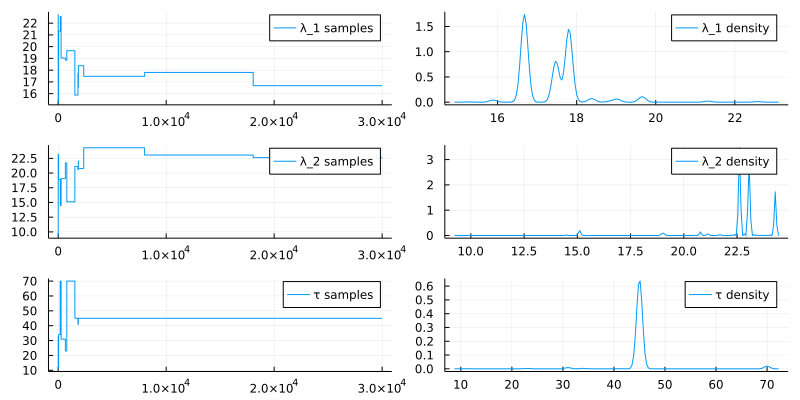

In [6]:
l1 = plot(λ_1_chain, label="λ_1 samples")
d1 = density(λ_1_chain, label="λ_1 density")
l2 = plot(λ_2_chain, label="λ_2 samples")
d2 = density(λ_2_chain, label="λ_2 density")
l3 = plot(τ_chain, label="τ samples")
d3 = density(τ_chain, label="τ density")
plot(l1, d1, l2, d2, l3, d3, layout=(3,2))

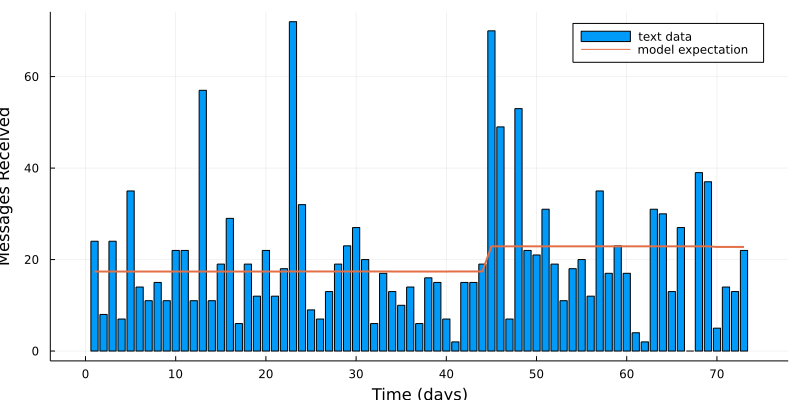

In [7]:
using LinearAlgebra
expected_texts = zeros(length(txt_data))
for day = eachindex(txt_data)
    ix = [day < τ for τ in τ_chain]
    expected_texts[day] = sum(ix ⋅ λ_1_chain) + sum(.!ix ⋅ λ_2_chain)
    expected_texts[day] = expected_texts[day] / length(ix)
end
bar(txt_data, xlabel="Time (days)", xticks=0:10:80, ylabel="Messages Received", label="text data")
plot!(expected_texts, label="model expectation", linewidth=2)

# Thoughts
- Gen is obviously the more low level PPL compared to Turing
- More boilerplate code is required
- Wording seems to be too unique
- Flexibility is a big plus:
    - sampling from other generative function
    - providing complex models like [inverse graphics](https://news.mit.edu/2015/better-probabilistic-programming-0413) or [complex priors from NNs](https://github.com/probcomp/Gen.jl/tree/master/examples/inverse_graphics)
- The idea of just providing a model which generates the data for inference is clear
- Hackable at all stages

 @license BSD-3 https://opensource.org/licenses/BSD-3-Clause
 Copyright (c) 2021, Tim Redick
 All rights reserved. 
